In [5]:
# importing all the dependencies
import pandas as pd # data frame
import numpy as np # matrix math
from glob import glob # file handling
import librosa # audio manipulation
from sklearn.utils import shuffle # shuffling of data
import os # interation with the OS
from random import sample # random selection
from tqdm import tqdm
from scipy import signal # audio processing
from scipy.io import wavfile # reading the wavfile

In [6]:
# fixed param
PATH = './input/train/audio/'

In [7]:
def load_files(path):
    # write the complete file loading function here, this will return
    # a dataframe having files and labels
    # loading the files
    train_labels = os.listdir(PATH)
    train_labels.remove('_background_noise_')
    train_labels.remove('LICENSE')
    train_labels.remove('README.md')
    train_labels.remove('testing_list.txt')
    train_labels.remove('validation_list.txt')
    
    
    labels_to_keep = ['on', 'off', '_background_noise_']

    train_file_labels = dict()
    for label in train_labels:
        files = os.listdir(PATH + '/' + label)
        for f in files:
            train_file_labels[label + '/' + f] = label

    train = pd.DataFrame.from_dict(train_file_labels, orient='index')
    train = train.reset_index(drop=False)
    train = train.rename(columns={'index': 'file', 0: 'folder'})
    train = train[['folder', 'file']]
    train = train.sort_values('file')
    train = train.reset_index(drop=True)

    def remove_label_from_file(label, fname):
        return path + label + '/' + fname[len(label)+1:]

    train['file'] = train.apply(lambda x: remove_label_from_file(*x), axis=1)
    train['label'] = train['folder'].apply(lambda x: x if x in labels_to_keep else 'unknown')

    labels_to_keep.append('unknown')

    return train, labels_to_keep

In [12]:
files = os.listdir(PATH + '/' + 'on')

In [19]:
train, labels_to_keep = load_files(PATH)

# making word2id dict
word2id = dict((c,i) for i,c in enumerate(sorted(labels_to_keep)))

# get some files which will be labeled as unknown
unk_files = train.loc[train['label'] == 'unknown']['file'].values
unk_files = sample(list(unk_files), 100)


array(['./input/train/audio/on/004ae714_nohash_0.wav',
       './input/train/audio/on/004ae714_nohash_1.wav',
       './input/train/audio/on/00b01445_nohash_0.wav',
       './input/train/audio/on/01b4757a_nohash_0.wav',
       './input/train/audio/on/01bb6a2a_nohash_0.wav',
       './input/train/audio/on/01bcfc0c_nohash_0.wav',
       './input/train/audio/on/01bcfc0c_nohash_1.wav',
       './input/train/audio/on/02ade946_nohash_0.wav',
       './input/train/audio/on/02ade946_nohash_1.wav',
       './input/train/audio/on/02ade946_nohash_2.wav',
       './input/train/audio/on/02ade946_nohash_3.wav',
       './input/train/audio/on/02ade946_nohash_4.wav',
       './input/train/audio/on/02e85b60_nohash_0.wav',
       './input/train/audio/on/02e85b60_nohash_1.wav',
       './input/train/audio/on/03c96658_nohash_0.wav',
       './input/train/audio/on/05b2db80_nohash_0.wav',
       './input/train/audio/on/0a196374_nohash_0.wav',
       './input/train/audio/on/0a196374_nohash_1.wav',
       './

In [20]:
labels_to_keep

['on', 'off', '_background_noise_', 'unknown']

In [21]:
word2id

{'_background_noise_': 0, 'off': 1, 'on': 2, 'unknown': 3}

In [22]:
unk_files[:10]

array(['./input/train/audio/on/004ae714_nohash_0.wav',
       './input/train/audio/on/004ae714_nohash_1.wav',
       './input/train/audio/on/00b01445_nohash_0.wav',
       './input/train/audio/on/01b4757a_nohash_0.wav',
       './input/train/audio/on/01bb6a2a_nohash_0.wav',
       './input/train/audio/on/01bcfc0c_nohash_0.wav',
       './input/train/audio/on/01bcfc0c_nohash_1.wav',
       './input/train/audio/on/02ade946_nohash_0.wav',
       './input/train/audio/on/02ade946_nohash_1.wav',
       './input/train/audio/on/02ade946_nohash_2.wav'], dtype=object)

In [23]:
train.sample(12)

,folder,file,label
14,off,./input/train/audio/off/02e85b60_nohash_0.wav,off
840,on,./input/train/audio/on/3d53244b_nohash_2.wav,on
888,on,./input/train/audio/on/4b39347d_nohash_1.wav,on
452,off,./input/train/audio/off/4e02d62d_nohash_2.wav,off
44,off,./input/train/audio/off/0bfec55f_nohash_0.wav,off
328,off,./input/train/audio/off/3bdf05d3_nohash_3.wav,off
628,on,./input/train/audio/on/1c76f5f3_nohash_1.wav,on
988,on,./input/train/audio/on/5c39594f_nohash_3.wav,on
604,on,./input/train/audio/on/1b42b551_nohash_0.wav,on
994,on,./input/train/audio/on/5cf1ecce_nohash_0.wav,on


In [24]:
from glob import glob
files = glob(PATH + '_bac*/*.wav')
print(files)

['./input/train/audio/_background_noise_/pink_noise.wav', './input/train/audio/_background_noise_/dude_miaowing.wav', './input/train/audio/_background_noise_/exercise_bike.wav', './input/train/audio/_background_noise_/doing_the_dishes.wav', './input/train/audio/_background_noise_/running_tap.wav', './input/train/audio/_background_noise_/white_noise.wav']


In [25]:
# silence background samples
all_sil = []
for s in files:
    sr, audio = wavfile.read(s)
    # converting the file into samples of 1 sec each
    len_ = int(len(audio)/sr)
    print(len_)
    for i in range(len_-1):
        sample_ = audio[i*sr:(i+1)*sr]
        all_sil.append(sample_)
print(len(all_sil))
print(all_sil[0].shape)
sil_data =  np.zeros((392, 16000, ))
for i,d in enumerate(all_sil):
    sil_data[i] = d
print(sil_data.shape)

60
61
61
95
61
60
392
(16000,)
(392, 16000)


/home/nguyenminh/.local/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [26]:
# Writing functions to extract the data, script from kdnuggets: 
# www.kdnuggets.com/2016/09/urban-sound-classification-neural-networks-tensorflow.html
def extract_feature(path):
	X, sample_rate = librosa.load(path)
	stft = np.abs(librosa.stft(X))
	mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
	chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
	mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
	contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
	tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
	return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(files, word2id, unk = False):
    # n: number of classes
    features = np.empty((0,193))
    one_hot = np.zeros(shape = (len(files), word2id[max(word2id)]))
    print(one_hot.shape)
    for i in tqdm(range(len(files))):
        f = files[i]
        mfccs, chroma, mel, contrast,tonnetz = extract_feature(f)
        ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
        features = np.vstack([features,ext_features])
        if unk == True:
            l = word2id['unknown']
            one_hot[i][l] = 1.
        else:
            l = word2id[f.split('/')[-2]]
            one_hot[i][l] = 1.
    return np.array(features), one_hot

In [27]:
files = train.loc[train['label'] != 'unknown']['file'].values
print(len(files))
print(files[:10])

1004
['./input/train/audio/off/004ae714_nohash_0.wav'
 './input/train/audio/off/004ae714_nohash_1.wav'
 './input/train/audio/off/00b01445_nohash_0.wav'
 './input/train/audio/off/01b4757a_nohash_0.wav'
 './input/train/audio/off/01bb6a2a_nohash_0.wav'
 './input/train/audio/off/01bb6a2a_nohash_1.wav'
 './input/train/audio/off/01bb6a2a_nohash_2.wav'
 './input/train/audio/off/01bcfc0c_nohash_0.wav'
 './input/train/audio/off/01d22d03_nohash_0.wav'
 './input/train/audio/off/02ade946_nohash_0.wav']


In [31]:
# playing around with the data for now
train_audio_path = './input/train/audio/'
filename = '/off/0a5636ca_nohash_0.wav' # --> 'Yes'
sample_rate, audio = wavfile.read(str(train_audio_path) + filename)

In [32]:
import matplotlib.pyplot as plt
import IPython.display as ipd
plt.figure(figsize = (15, 4))
plt.plot(audio)
ipd.Audio(audio, rate=sample_rate)

In [33]:
# goto: https://medium.com/@ageitgey/machine-learning-is-fun-part-6-how-to-do-speech-recognition-with-deep-learning-28293c162f7a
# We convert it into chunks of 20ms each i.e. units of 320 
audio_chunks = []
n_chunks = int(audio.shape[0]/320)
for i in range(n_chunks):
    chunk = audio[i*320: (i+1)*320]
    audio_chunks.append(chunk)
audio_chunk = np.array(audio_chunks)

In [34]:
# we now convert it to spertogram
# goto: https://www.kaggle.com/davids1992/data-visualization-and-investigation
def log_specgram(audio, sample_rate, window_size=10,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    _, _, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return np.log(spec.T.astype(np.float32) + eps)


(81, 100)


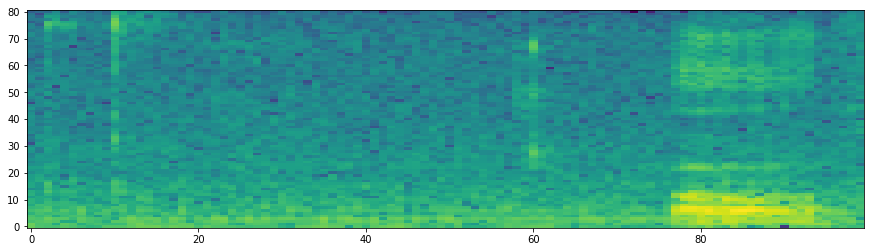

In [35]:
spectrogram = log_specgram(audio, sample_rate, 10, 0)
spec = spectrogram.T
print(spec.shape)
plt.figure(figsize = (15,4))
plt.imshow(spec, aspect='auto', origin='lower')

In [36]:
# make labels and convert them into one hot encodings
labels = sorted(labels_to_keep)
word2id = dict((c,i) for i,c in enumerate(labels))
label = train['label'].values
label = [word2id[l] for l in label]
print(labels)
def make_one_hot(seq, n):
    # n --> vocab size
    seq_new = np.zeros(shape = (len(seq), n))
    for i,s in enumerate(seq):
        seq_new[i][s] = 1.
    return seq_new
one_hot_l = make_one_hot(label, 12)

['_background_noise_', 'off', 'on', 'unknown']


In [37]:
print(one_hot_l[10:15])

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [38]:
# getting all the paths to the files
paths = []
folders = train['folder']
files = train['file']
for i in range(len(files)):
    path = str(files[i])
    paths.append(path)

In [39]:
def audio_to_data(path):
    # we take a single path and convert it into data
    sample_rate, audio = wavfile.read(path)
    spectrogram = log_specgram(audio, sample_rate, 10, 0)
    return spectrogram.T

def paths_to_data(paths,labels):
    data = np.zeros(shape = (len(paths), 81, 100))
    indexes = []
    for i in tqdm(range(len(paths))):
        audio = audio_to_data(paths[i])
        if audio.shape != (81,100):
            indexes.append(i)
        else:
            data[i] = audio
    final_labels = [l for i,l in enumerate(labels) if i not in indexes]
    print('Number of instances with inconsistent shape:', len(indexes))
    return data[:len(data)-len(indexes)], final_labels, indexes

In [40]:
d,l,indexes = paths_to_data(paths,one_hot_l)

100%|██████████| 1004/1004 [00:06<00:00, 156.90it/s]

Number of instances with inconsistent shape: 106


In [41]:
labels = np.zeros(shape = [d.shape[0], len(l[0])])
for i,array in enumerate(l):
    for j, element in enumerate(array):
        labels[i][j] = element
print(labels.shape)

(898, 12)


In [42]:
print(d.shape)
print(labels.shape)

(898, 81, 100)
(898, 12)


In [43]:
d,labels = shuffle(d,labels)

In [70]:
print(d[0].shape)
print(labels[0])


(81, 100)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [47]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [48]:
import tensorflow as tf

In [49]:
model = Sequential()
model.add(LSTM(256, input_shape = (81, 100)))
# model.add(Dense(1028))
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(12, activation = 'softmax'))
model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                1548      
Total params: 400,012
Trainable params: 400,012
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.fit(d, labels, batch_size = 1024, epochs = 10)

Epoch 1/10
898/898 [==============================] - 5s 5ms/step - loss: 0.0886 - acc: 0.0167
Epoch 2/10
898/898 [==============================] - 3s 3ms/step - loss: 0.0708 - acc: 0.3396
Epoch 3/10
898/898 [==============================] - 3s 3ms/step - loss: 0.0603 - acc: 0.4989
Epoch 4/10
898/898 [==============================] - 3s 3ms/step - loss: 0.0437 - acc: 0.6492
Epoch 5/10
898/898 [==============================] - 3s 3ms/step - loss: 0.0482 - acc: 0.6091
Epoch 6/10
898/898 [==============================] - 3s 3ms/step - loss: 0.0422 - acc: 0.6503
Epoch 7/10
898/898 [==============================] - 3s 3ms/step - loss: 0.0434 - acc: 0.6002
Epoch 8/10
898/898 [==============================] - 3s 3ms/step - loss: 0.0414 - acc: 0.6470
Epoch 9/10
898/898 [==============================] - 3s 3ms/step - loss: 0.0372 - acc: 0.6904
Epoch 10/10
898/898 [==============================] - 3s 3ms/step - loss: 0.0393 - acc: 0.6626


In [69]:
storage = './model/LSTM_model/'
model_json = model.to_json()
with open(storage + "LSTM_model.json", 'w') as json_file:
    json_file.write(model_json)
model.save_weights(storage + 'LSTM_model.h5')

In [95]:
print(type(d[0]))
d[0].shape
for i in range(10):
    print(labels[i])
    print(np.argmax(labels[i]))

<class 'numpy.ndarray'>
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1


In [120]:
sample_pred = np.random.random_integers(0, d.shape[0], size = (100))

def result(a):
    if(a == 1 ):
        return 'off'
    elif ( a == 2):
        return 'on'
    else:
        return 'unknow'

for i in sample_pred:
    y_pred = model.predict_classes(d[i].reshape((1, d.shape[1], d.shape[2])))
    print('y_label: ', result(np.argmax(labels[i])), 'y pred: ', result(y_pred))

/home/nguyenminh/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 898 + 1) instead
  """Entry point for launching an IPython kernel.


y_label:  on y pred:  on
y_label:  off y pred:  on
y_label:  off y pred:  on
y_label:  on y pred:  on
y_label:  off y pred:  off
y_label:  on y pred:  on
y_label:  on y pred:  on
y_label:  off y pred:  off
y_label:  on y pred:  on
y_label:  off y pred:  on
y_label:  on y pred:  on
y_label:  on y pred:  on
y_label:  on y pred:  on
y_label:  off y pred:  off
y_label:  on y pred:  on
y_label:  on y pred:  on
y_label:  on y pred:  on
y_label:  on y pred:  on
y_label:  off y pred:  on
y_label:  on y pred:  on
y_label:  on y pred:  on
y_label:  on y pred:  on
y_label:  on y pred:  on
y_label:  off y pred:  on
y_label:  on y pred:  off
y_label:  on y pred:  off
y_label:  on y pred:  on
y_label:  off y pred:  off
y_label:  on y pred:  on
y_label:  off y pred:  on
y_label:  off y pred:  off
y_label:  off y pred:  off
y_label:  on y pred:  on
y_label:  off y pred:  on
y_label:  on y pred:  on
y_label:  on y pred:  on
y_label:  off y pred:  on
y_label:  on y pred:  on
y_label:  on y pred:  on
y_l